In [7]:
import yfinance as yf
import pandas as pd

data = yf.download('BTC-USD', period = 'max', interval = '1mo')
data.to_csv("test_file.csv")

[*********************100%***********************]  1 of 1 completed


In [42]:
def clean_yfinance_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Приводимо колонки до однорівневого списку, відкидаючи верхній рівень
    df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    
    # Переконаймося, що індекс — це datetime
    df.index = pd.to_datetime(df.index)

    # Сортуємо за датою (опціонально)
    df.sort_index(inplace=True)

    return df


In [43]:
# Приклад: зчитування з CSV з багаторівневим хедером
df_raw = pd.read_csv("test_file.csv", header=[0, 1], index_col=0)

# Очистка
df_clean = clean_yfinance_dataframe(df_raw)
print(df_clean)

                    Close           High           Low           Open  \
Date                                                                    
2014-09-01     386.944000     468.174011    372.239990     465.864014   
2014-10-01     338.321014     411.697998    289.295990     387.427002   
2014-11-01     378.046997     457.092987    320.626007     338.649994   
2014-12-01     320.192993     384.037994    304.231995     378.248993   
2015-01-01     217.464005     320.434998    171.509995     320.434998   
...                   ...            ...           ...            ...   
2025-01-01  102405.023438  109114.882812  89260.101562   93425.101562   
2025-02-01   84373.007812  102755.726562  78248.914062  102402.796875   
2025-03-01   82548.914062   95043.437500  76624.250000   84373.867188   
2025-04-01   94207.312500   95768.390625  74436.679688   82551.921875   
2025-05-01   97227.054688   97905.898438  93399.859375   94212.859375   

                   Volume  
Date                  

In [44]:
df_clean.dtypes

Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import io

# Прогноз ціни з ARIMA
def plot_crypto_with_forecast_first(symbol, period="max", interval = "1mo", forecast_periods=1):
    
    data = yf.download(symbol, period=period, interval=interval)
    data = clean_yfinance_dataframe(data)
    df = data[['Close']].dropna()

    # Препроцесинг для ARIMA
    df['Close_box'], lmbda = boxcox(df['Close'])
    df['Weighted_Price_box'], lmbda = stats.boxcox(df.Close)
    df['prices_box_diff'] = df.Weighted_Price_box - df.Weighted_Price_box.shift(12)
    df['prices_box_diff2'] = df.prices_box_diff - df.prices_box_diff.shift(1)


    # Параметри моделі
    Ps = range(0, 2)
    qs = range(0, 2)
    ps = range(0, 2)
    Qs = range(0, 2)
    D = 1
    d = 1

    parameters = list(product(ps, qs, Ps, Qs))
    best_aic = float("inf")
    best_model = None

    warnings.filterwarnings('ignore')

    for param in parameters:
        try:
            model=sm.tsa.statespace.SARIMAX(df.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
        except:
            continue

    # Прогноз
    pred = best_model.predict(start=0, end=len(df) + forecast_periods - 1)
    forecast = inv_boxcox(pred, lmbda)
    df['Forecast'] = forecast[:len(df)]
    future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, forecast_periods + 1)]
    future_df = pd.DataFrame(forecast[-forecast_periods:], index=future_dates, columns=['Forecast'])

    # Побудова графіку
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Історичні дані')
    plt.plot(df.index, df['Forecast'], label='ARIMA (in-sample)', linestyle='--')
    plt.plot(future_df.index, future_df['Forecast'], label='Прогноз', color='red')
    plt.title(f"{symbol}: історія та прогноз")
    plt.xlabel("Дата")
    plt.ylabel("Ціна (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Збереження у пам’ять
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return buf


In [61]:
out = plot_crypto_with_forecast_first(symbol = "ETC-USD")


[*********************100%***********************]  1 of 1 completed


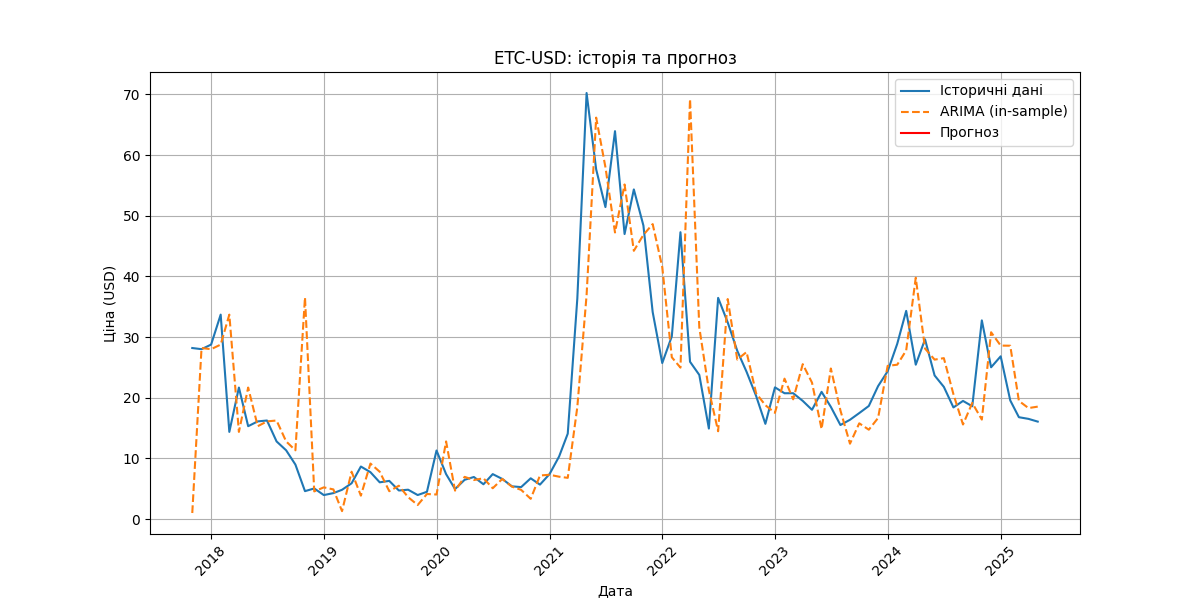

In [62]:
from PIL import Image
import IPython.display as display

img = Image.open(out)
display.display(img)

In [21]:
df_clean.dtypes

Price
Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

In [58]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import statsmodels.api as sm
from itertools import product
import warnings
import io

def plot_crypto_with_forecast(symbol, period="max", interval="1mo", forecast_periods=1):
    data = yf.download(symbol, period=period, interval=interval)
    data = clean_yfinance_dataframe(data)
    df = data[['Close']].dropna()

    if len(df) < 24:
        raise ValueError("Недостатньо даних для сезонного ARIMA. Потрібно щонайменше 24 місяці.")

    # BoxCox трансформація
    df['Close_box'], lmbda = boxcox(df['Close'])
    df['prices_box_diff'] = df['Close_box'] - df['Close_box'].shift(12)
    df['prices_box_diff2'] = df['prices_box_diff'] - df['prices_box_diff'].shift(1)
    df.dropna(inplace=True)

    # Підбір найкращих параметрів SARIMA
    Ps = range(0, 2)
    qs = range(0, 2)
    ps = range(0, 2)
    Qs = range(0, 2)
    D = 1
    d = 1

    parameters = list(product(ps, qs, Ps, Qs))
    best_aic = float("inf")
    best_model = None

    warnings.filterwarnings('ignore')

    for param in parameters:
        try:
            model = sm.tsa.statespace.SARIMAX(
                df['Close_box'],
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], 12)
            ).fit(disp=False)

            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
        except:
            continue

    # Прогноз: історичний + майбутній
    pred_in_sample = best_model.predict(start=0, end=len(df)-1)
    forecast_future = best_model.predict(start=len(df), end=len(df)+forecast_periods-1)

    forecast_in_sample = inv_boxcox(pred_in_sample, lmbda)
    forecast_future = inv_boxcox(forecast_future, lmbda)

    df['Forecast'] = forecast_in_sample
    future_dates = [df.index[-1] + pd.DateOffset(months=i) for i in range(1, forecast_periods + 1)]
    future_df = pd.DataFrame(forecast_future, index=future_dates, columns=['Forecast'])

    # Візуалізація
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Історичні дані')
    plt.plot(df.index, df['Forecast'], label='ARIMA (in-sample)', linestyle='--')
    plt.plot(future_df.index, future_df['Forecast'], label='Прогноз', color='red')
    plt.title(f"{symbol}: історія та прогноз")
    plt.xlabel("Дата")
    plt.ylabel("Ціна (USD)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Збереження графіка в буфер
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    # Результат прогнозу і рекомендація
    last_price = df['Close'].iloc[-1]
    forecasted_price = forecast_future[-1]
    change_pct = ((forecasted_price - last_price) / last_price) * 100

    if change_pct > 3:
        recommendation = "Купувати актив"
    elif change_pct < -3:
        recommendation = "Продавати актив"
    else:
        recommendation = "Утримувати актив"

    print(f"\n--- {symbol} ---")
    print(f"Остання ціна: {last_price:.2f} USD")
    print(f"Прогноз через {forecast_periods} міс.: {forecasted_price:.2f} USD")
    print(f"Зміна: {change_pct:.2f}%")
    print(f"Рекомендація: {recommendation}")

    return buf


In [64]:
plot_crypto_with_forecast("BNB-USD", period="max", interval="1mo", forecast_periods=1)


[*********************100%***********************]  1 of 1 completed



--- BNB-USD ---
Остання ціна: 602.38 USD
Прогноз через 1 міс.: 532.20 USD
Зміна: -11.65%
Рекомендація: Продавати актив
